In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))
    ])
    # choose the training and test datasets
    train_data = datasets.MNIST(root='data',
                                train=True,
                                download=True,
                                transform=transform)

    test_data = datasets.MNIST(root='data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)

    return train_loader, test_loader, valid_loader

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)



Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
def train_model(model, batch_size, patience, n_epochs):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
batch_size = 256
n_epochs = 100

train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)


[  1/100] train_loss: 0.98260 valid_loss: 0.39015
Validation loss decreased (inf --> 0.390149).  Saving model ...
[  2/100] train_loss: 0.52568 valid_loss: 0.31922
Validation loss decreased (0.390149 --> 0.319217).  Saving model ...
[  3/100] train_loss: 0.45076 valid_loss: 0.27561
Validation loss decreased (0.319217 --> 0.275614).  Saving model ...
[  4/100] train_loss: 0.40665 valid_loss: 0.23779
Validation loss decreased (0.275614 --> 0.237793).  Saving model ...
[  5/100] train_loss: 0.38781 valid_loss: 0.22793
Validation loss decreased (0.237793 --> 0.227926).  Saving model ...
[  6/100] train_loss: 0.36428 valid_loss: 0.20851
Validation loss decreased (0.227926 --> 0.208510).  Saving model ...
[  7/100] train_loss: 0.34724 valid_loss: 0.20217
Validation loss decreased (0.208510 --> 0.202171).  Saving model ...
[  8/100] train_loss: 0.34303 valid_loss: 0.19217
Validation loss decreased (0.202171 --> 0.192165).  Saving model ...
[  9/100] train_loss: 0.33134 valid_loss: 0.18778
Val

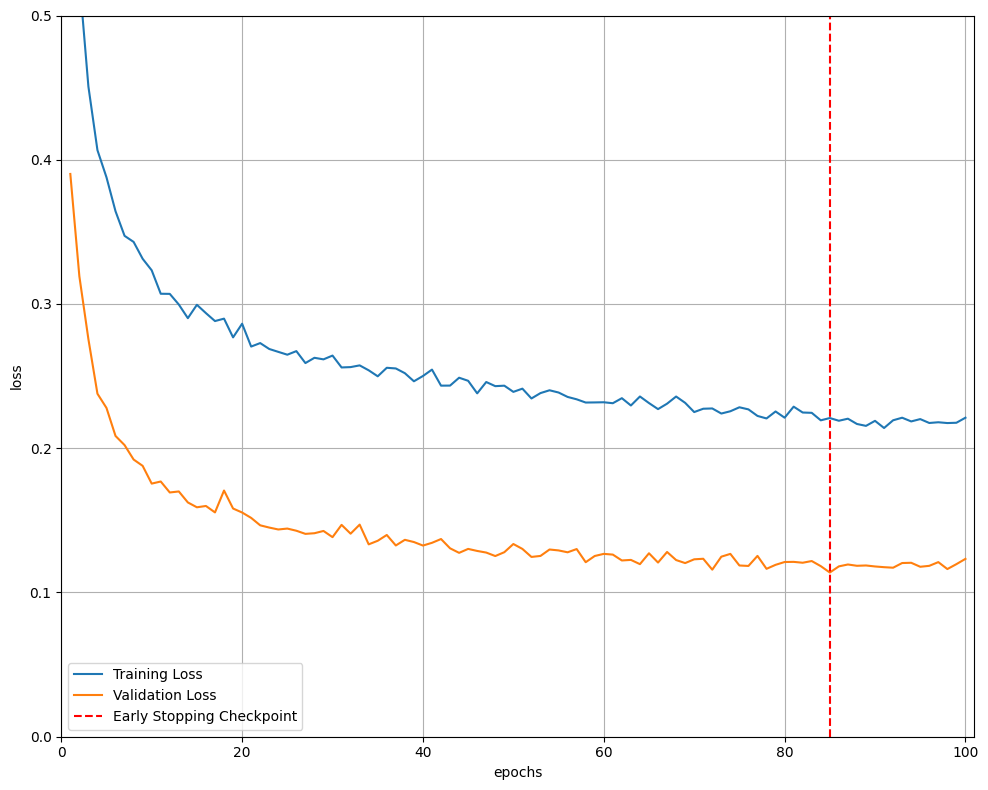

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.109444

Test Accuracy of     0: 99% (970/979)
Test Accuracy of     1: 98% (1115/1133)
Test Accuracy of     2: 97% (1009/1030)
Test Accuracy of     3: 94% (956/1008)
Test Accuracy of     4: 96% (950/980)
Test Accuracy of     5: 97% (865/890)
Test Accuracy of     6: 96% (926/956)
Test Accuracy of     7: 96% (995/1027)
Test Accuracy of     8: 94% (922/973)
Test Accuracy of     9: 93% (941/1008)

Test Accuracy (Overall): 96% (9649/9984)


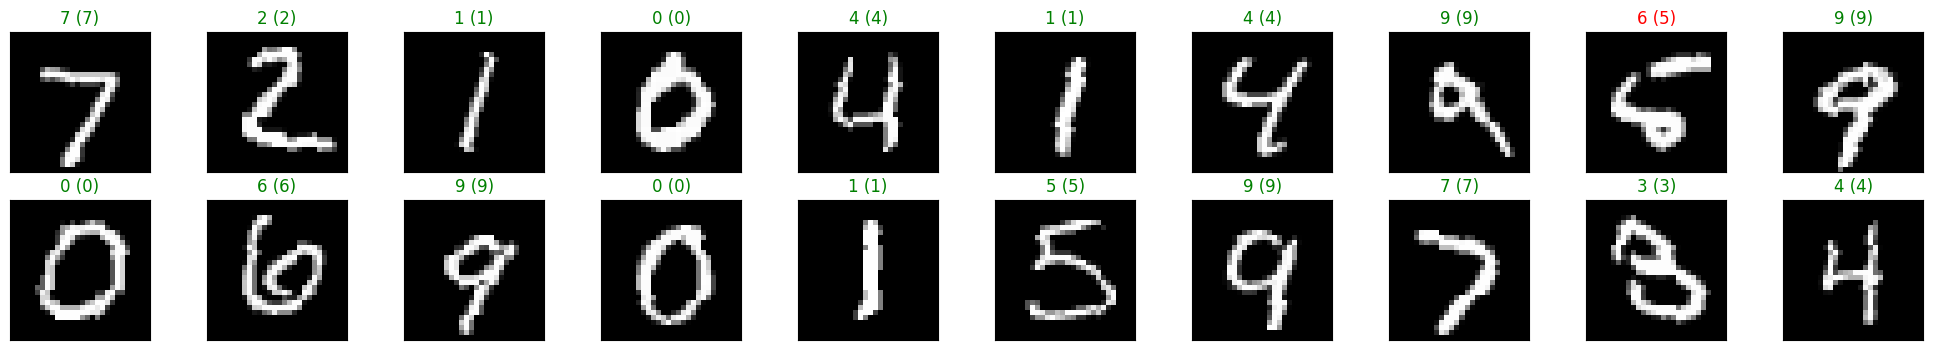

In [ ]:
# obtain one batch of test images
images, labels = next(iter(test_loader))

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))